In [1]:
!jupyter nbconvert --to html CMD_lab_part2_edit.ipynb

[NbConvertApp] Converting notebook CMD_lab_part2_edit.ipynb to html
[NbConvertApp] Writing 1879704 bytes to CMD_lab_part2_edit.html


# CMD Lab 2:
## Color Correction & Isochrone Fitting

### Color Correction

Last week, you used your photometry tools to make a CMD of M36. However, that was entirely in instrumental magnitudes. Now, we will correct the CMD to be in apparent magnitudes so we can actually fit an isochrone to the data. In Dropbox/Handouts, there is a file called "photometry filter calibration with standards." Depending how you created your original CMD, this step will be more or less difficult. You have a few options:

1) Use the "region" tools in ds9 to measure the flux of a few stars and compare that to standard magnitudes. 

2) Use either photutils or your aperture tool to measure the flux around a few stars and compare to standard magnitudes.

3) Use the flux measured for your automatically identified stars from DAOStarFinder and compare to standard magnitudes. (NOTE: this will probably take the longest to code)

You can get your comparison magnitudes from http://simbad.u-strasbg.fr/simbad/ First, type in your star cluster into the "basic search bar." Then, on the right, use "AladinLite" to query around the center of the cluster and get the B & V magnitudes. 

AS A TEAM, identify at least TWENTY (20) stars for your color correction. Do a Least-Squares fit to get the color correction terms. You should also correct from instrumental b & v to aparent b & v. It is acceptable to assume T_b and T_v are zero for this.

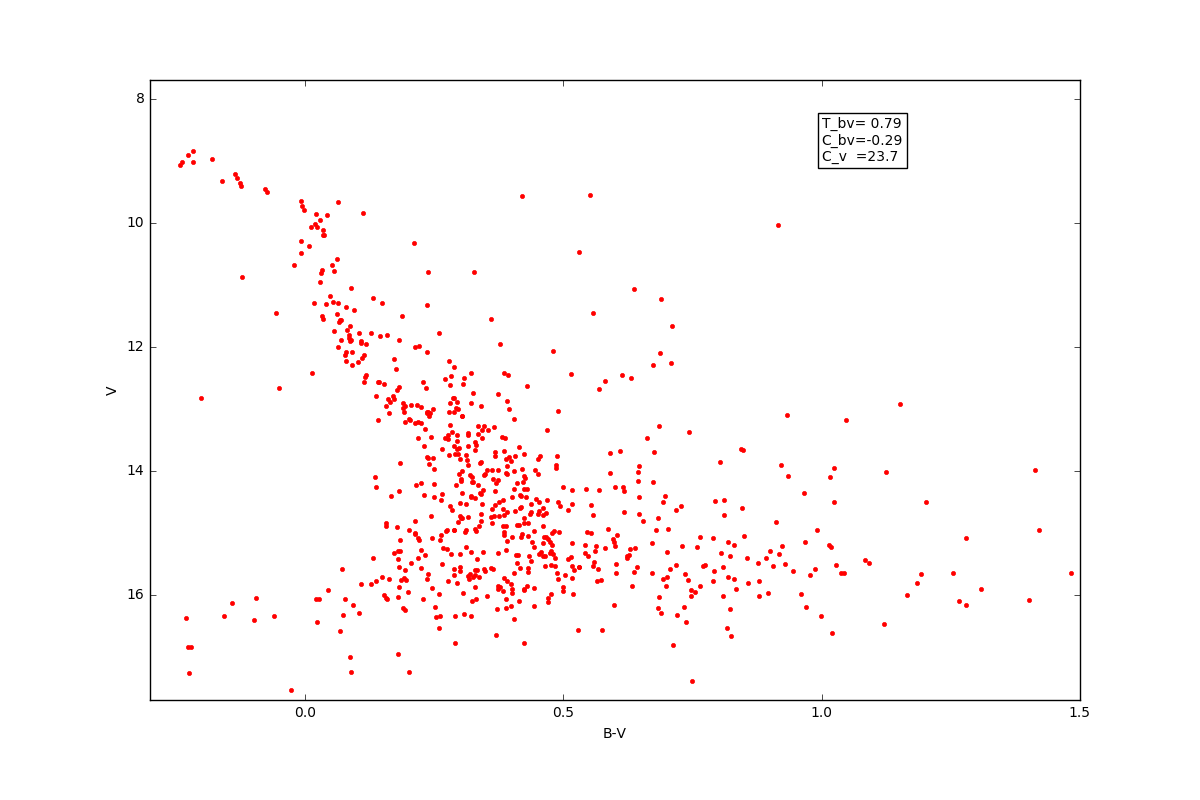

In [9]:
from IPython.display import Image
Image(filename='color_corrected_CMD.png') 

### Isochrone Fitting

Now that we have corrected to aparent magnitude and color, we can begin the isochrone fitting. This time, we will be using "chi-squared" ($\chi^2$) fitting, which is a different fitting algorithm than we've used before. 

$\chi^2=\sum_i \frac{(y_i-f(x_i))^2}{\sigma_i^2}$

We will calculate a chi-squared value for each theoretical isochrone. The best fit isochrone is the one which returns the smallest $\chi^2.$ Now, note that we do not have uncertainties for our data, so when you calculate your chi-squared, assume $\sigma_i=\sigma=1.$

For our lab, we have to make a few special considerations. Firstly, not all of our data belongs to our star cluser, so we should probably use np.where to only get stars with bright enough v-magnitudes. Maybe we also want to only consider stars with specific colors? Choose what magnitudes and colors you want to consider to only select main sequence stars. (Feel free to use more complicated selection criteria if you want!)

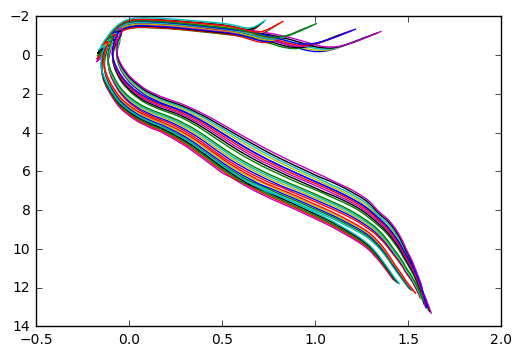

In [49]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import interpolate
import glob

filelist=glob.glob("C:/Users/icema/OneDrive/Documents/Isochrones/yapsi_w_X0p*")
age=0.2
for f in filelist:
    isochrone_data=Table.read(f,format='ascii')
    mask=np.where(isochrone_data['col1']==age)
    single_age_isochrone=isochrone_data[mask]
    plt.plot(single_age_isochrone['col8'],single_age_isochrone['col6'])
plt.ylim(reversed(plt.ylim()))
plt.show()

Now, it is time to actually do a chi-squared minimization. It is easier to constrain age than metallicity. So, choose 1 isochrone file, and we will find the best fit age for the that file. Below is my code for selecting a best-fit age and metallicity. Remember that you can just do a visual fit. First, I will show an example of fitting the isochrone by hand.

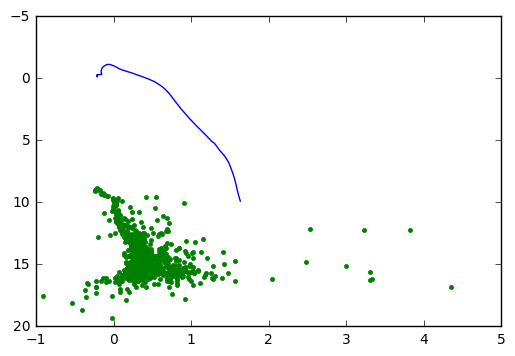

In [40]:
isochrone_data=Table.read("Isochrones/yapsi_w_X0p602357_Z0p027643.dat",format='ascii')
V,BV=np.loadtxt("CMD_data.txt")
#first find a rough value for the distance modulus
mask=np.where(isochrone_data['col1']==0.001)
single_age_isochrone=isochrone_data[mask]
plt.plot(single_age_isochrone['col8'],single_age_isochrone['col6'])
plt.plot(BV,V,'.')
plt.ylim(reversed(plt.ylim()))
plt.show()

Looks like 10 is a good estimate for the distance modulus. Now, plot the data with each age to find the best-fit age.

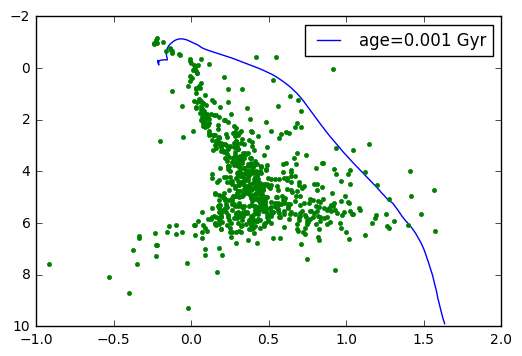

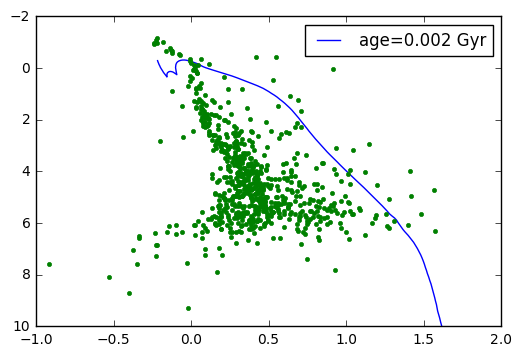

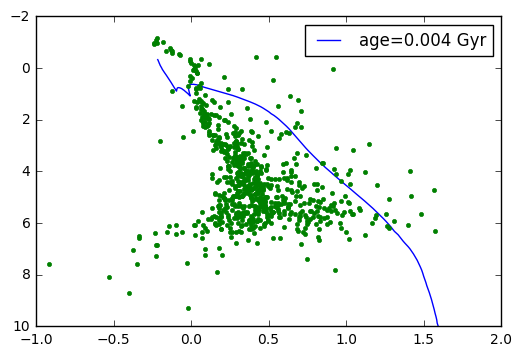

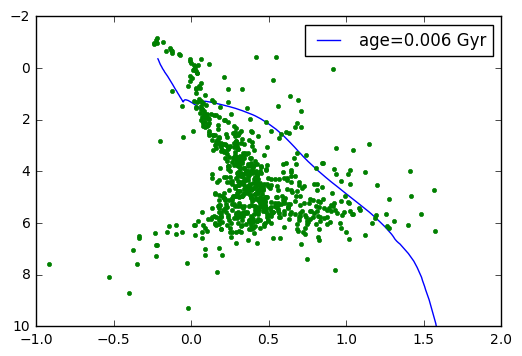

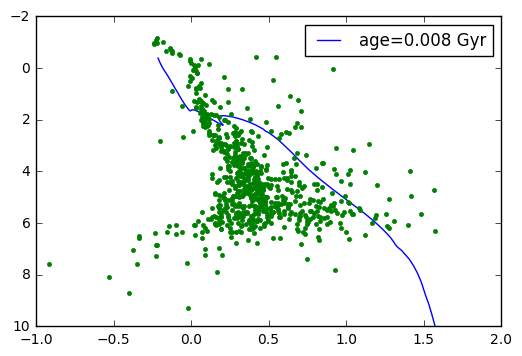

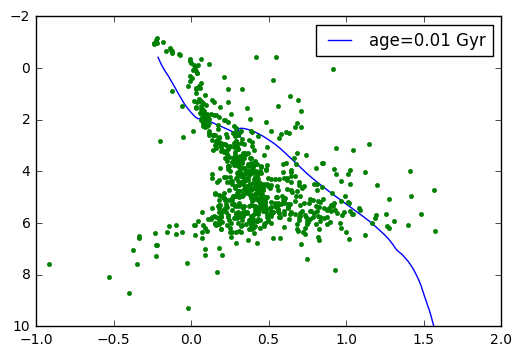

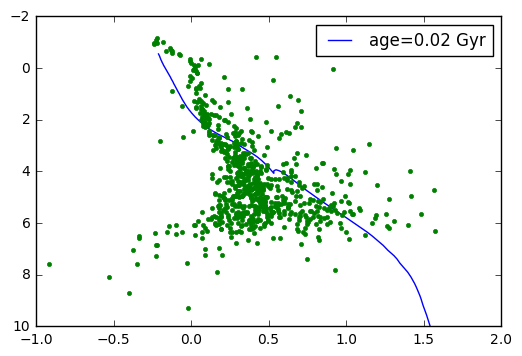

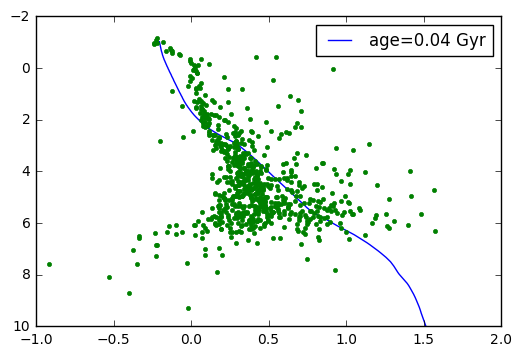

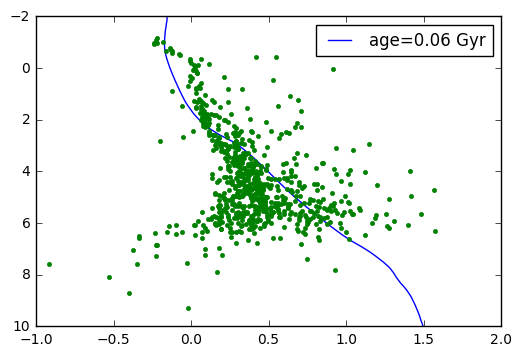

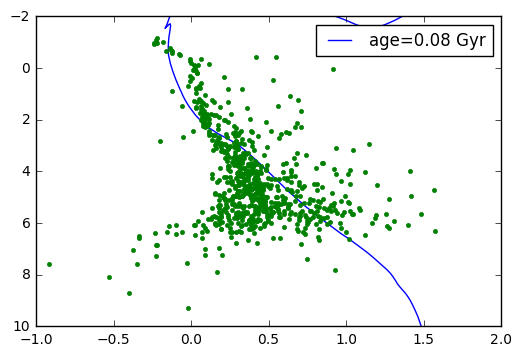

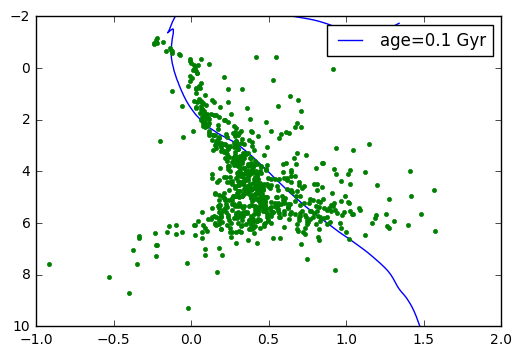

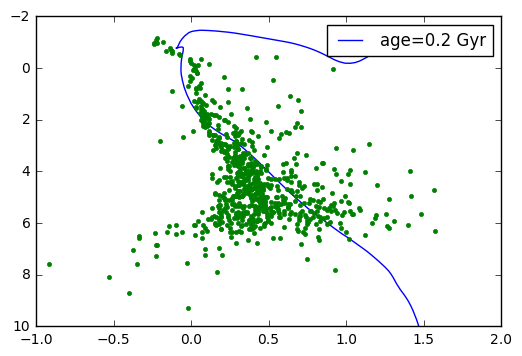

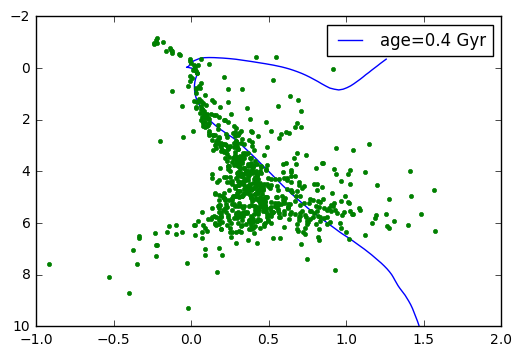

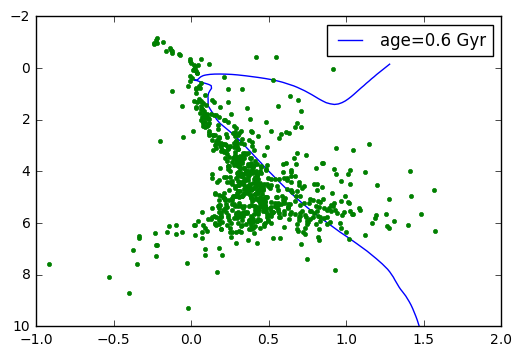

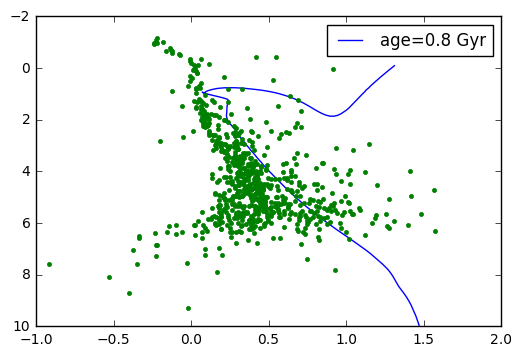

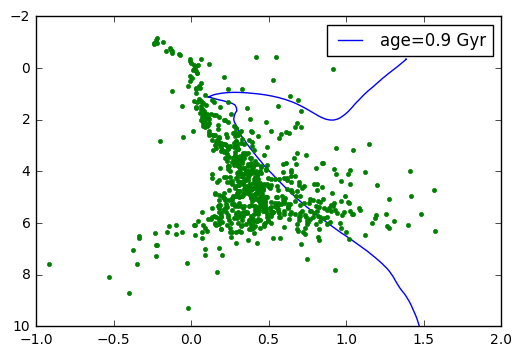

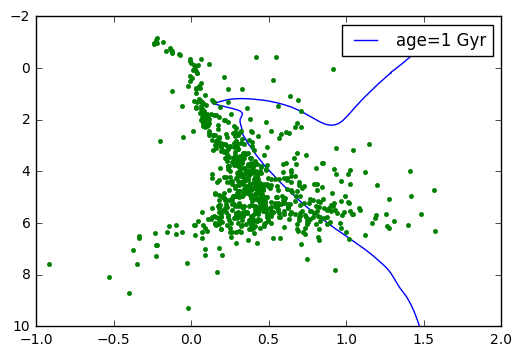

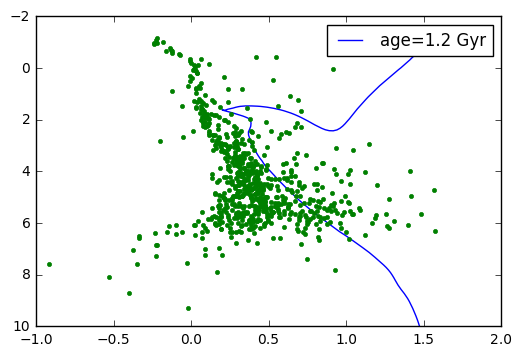

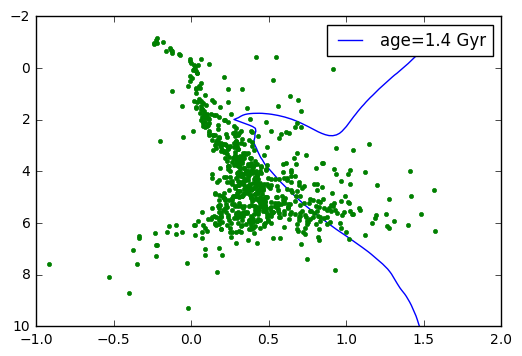

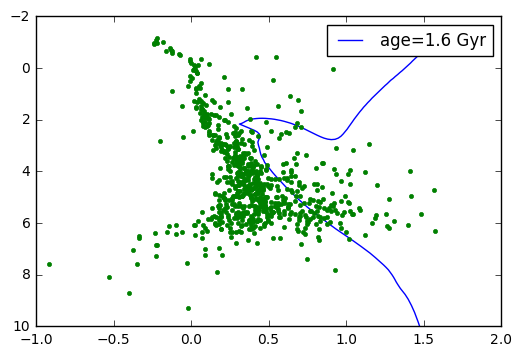

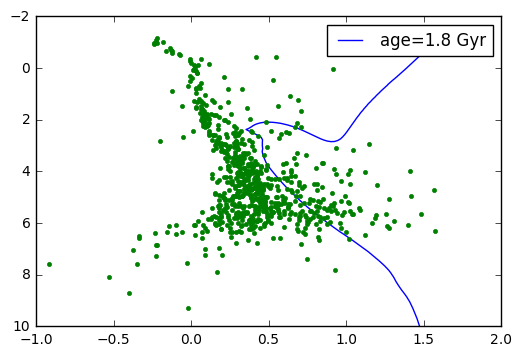

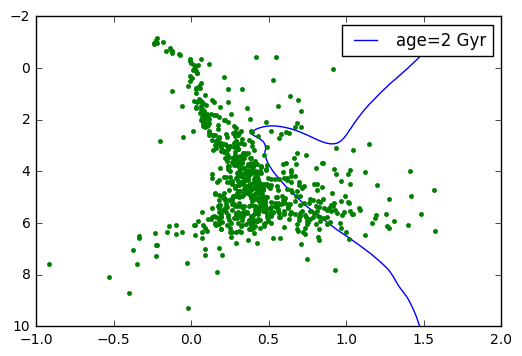

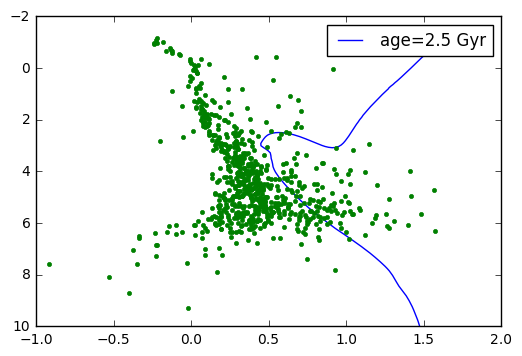

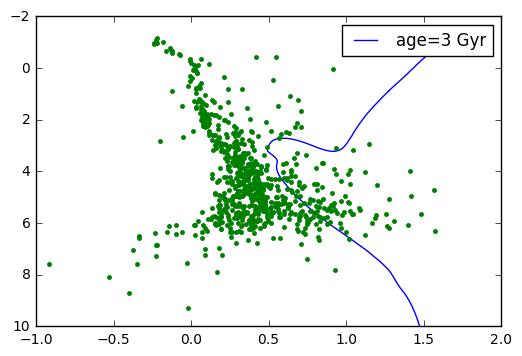

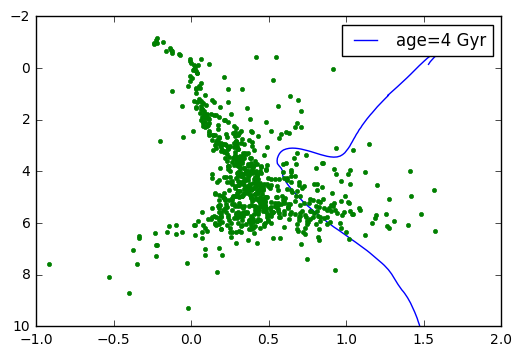

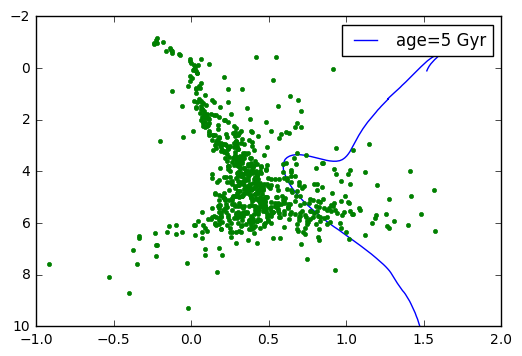

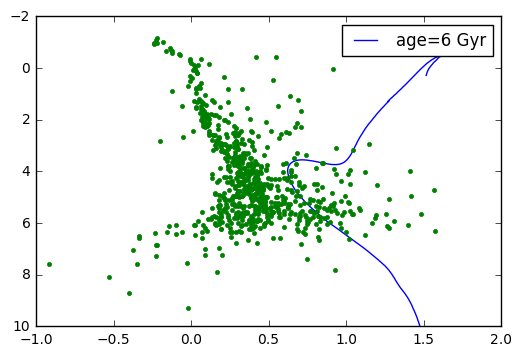

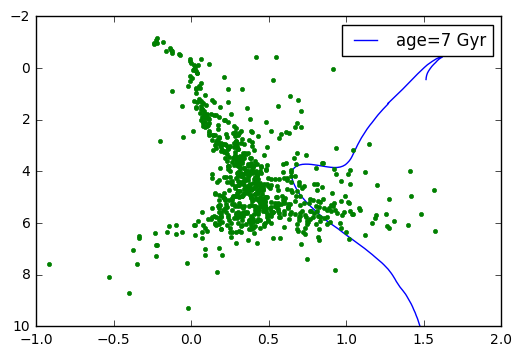

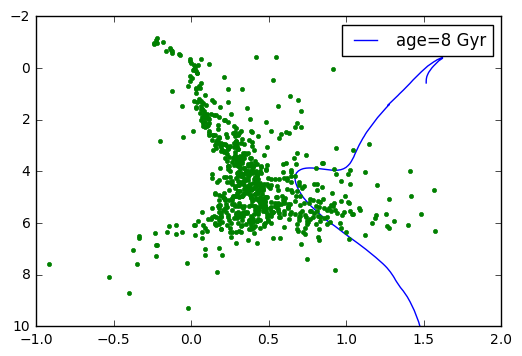

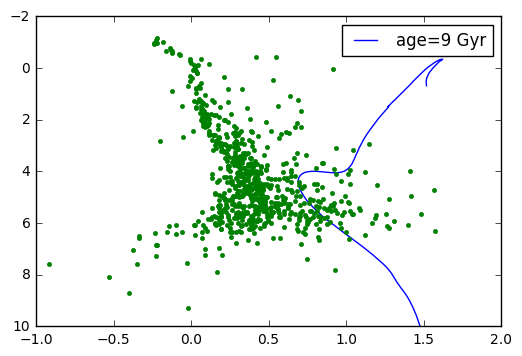

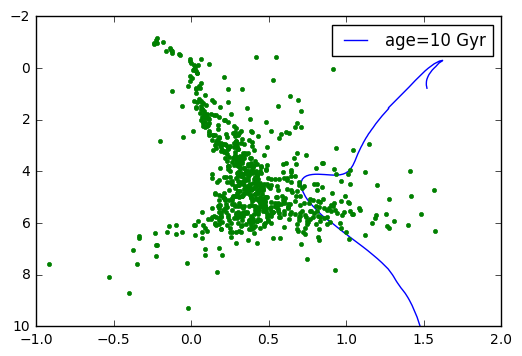

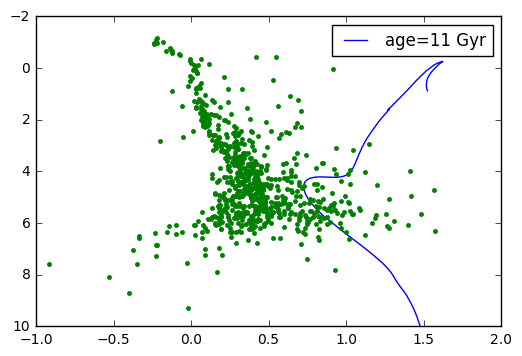

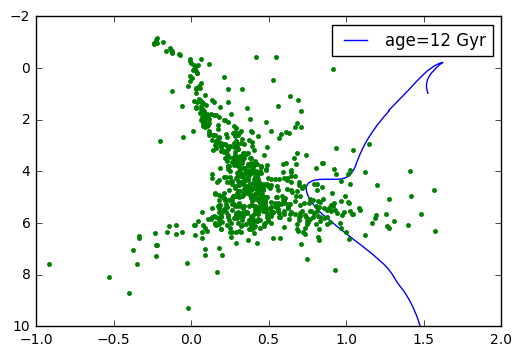

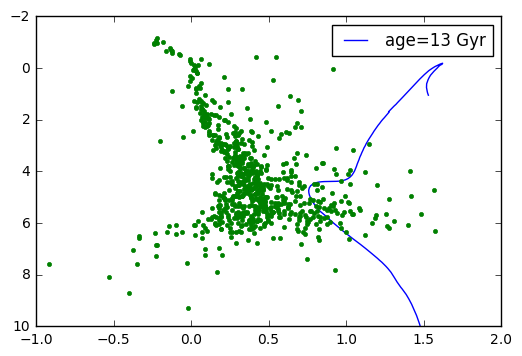

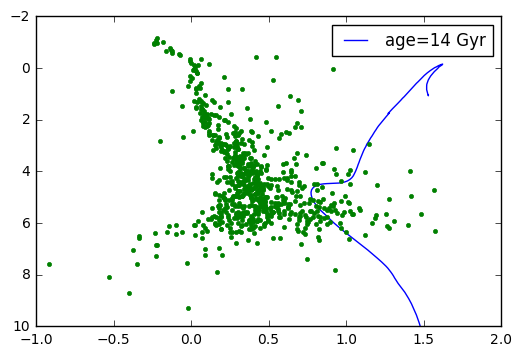

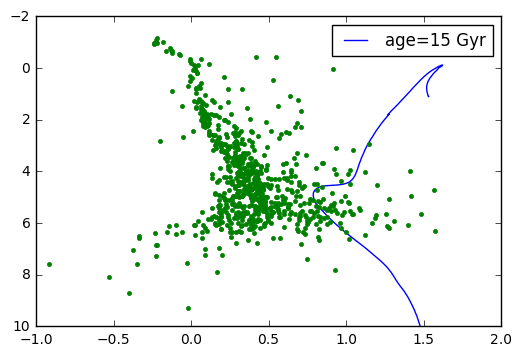

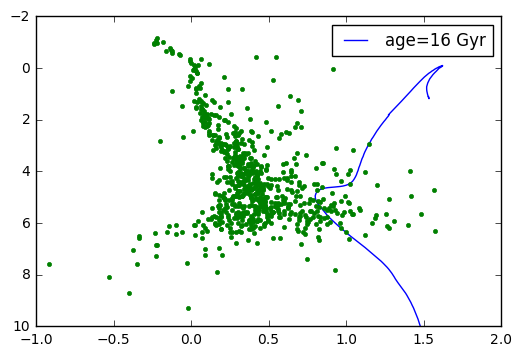

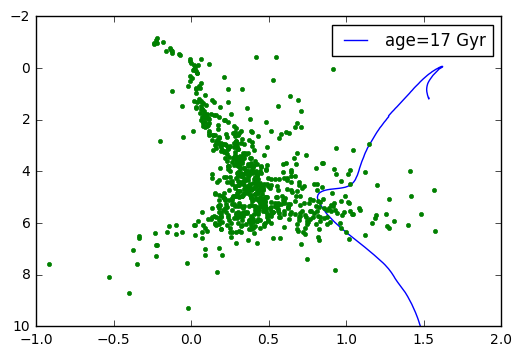

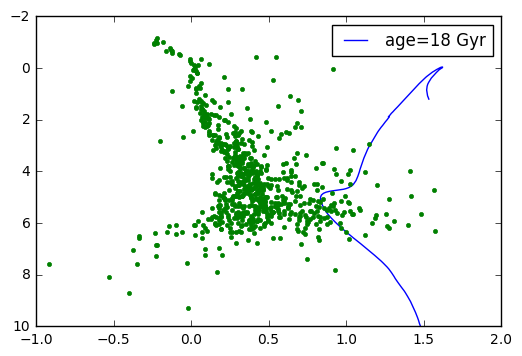

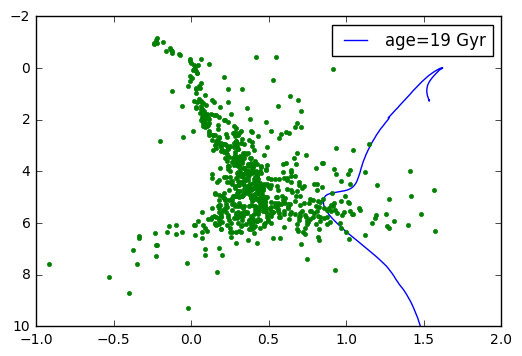

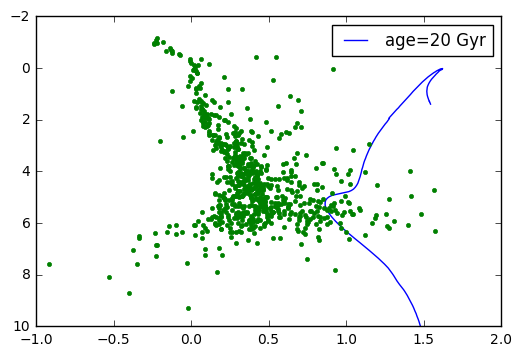

In [45]:
distance_modulus=10
isochrone_data=Table.read("Isochrones/yapsi_w_X0p602357_Z0p027643.dat",format='ascii')
ages=np.unique(isochrone_data['col1'])
for age in ages:
    mask=np.where(isochrone_data['col1']==age)
    single_age_isochrone=isochrone_data[mask]
    plt.plot(single_age_isochrone['col8'],single_age_isochrone['col6'],label='age=%g Gyr'%age)
    plt.plot(BV,V-distance_modulus,'.')
    plt.ylim(10,-2)
    plt.xlim(-1,2)
    plt.legend()
    plt.show()

So, if we ignore the brightest stars (which we argued in class might not be reliable), it looks like an age of 200 Myr might be the best fit. You would use a similar code (up to you to write) to find the best fit He-abundance and metallicity. Below, I have put an automated method for finding the best age. An important step in doing it automatically is to only use the data that is part of the main sequence. The first line below makes a mask of only stars with V<14 and -0.1<BV<0.5. You have to change this appropriately for your data. 

In [56]:
#First iterate over age to find the cluster age

mask=(V<14) & (BV<0.5) & (-0.1<BV)#MAKE SURE TO CHOOSE VALUES APPROPRIATE FOR YOUR STAR CLUSTER
xd=BV[mask]
yd=V[mask]

fit=[]
isochrone_file="Isochrones/yapsi_w_X0p602357_Z0p027643.dat"
isochrone=Table.read(isochrone_file, format='ascii') #open up one of the files
ages=np.unique(isochrone['col1'])
for ii,age in enumerate(ages):
    single_age_isochrone=isochrone[isochrone['col1']==age]
    
    x=single_age_isochrone['col8']
    y=single_age_isochrone['col6']
    #get the main-sequence part of the isochrone
    for i in range(len(x)):
        try:
            if x[i+1]>x[i]:
                break
        except IndexError:
            i=len(x)
            break
    x=x[:i]
    y=y[:i]
    yoff=np.mean(y)-np.nanmean(yd)
    g=interpolate.interp1d(x,y)
    mask=((xd<=np.max(x)) & (xd>=np.min(x)))
    xdm=xd[mask]
    ydm=yd[mask]+yoff
    if len(ydm)==0:
        chi2=np.inf
    else:
        chi2=np.sum((ydm-g(xdm))**2)/(len(ydm)-1)
    fit.append([isochrone_file,age,chi2])
    print("%.2f%% finished"%(100.0*(ii+1)/len(ages)))
    
ichi2min=np.argmin(np.array(fit)[:,2])
print('best fit file name | age | chi2/(N-1)')
print(fit[ichi2min])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


2.44% finished
4.88% finished
7.32% finished
9.76% finished
12.20% finished
14.63% finished
17.07% finished
19.51% finished
21.95% finished
24.39% finished
26.83% finished
29.27% finished
31.71% finished
34.15% finished
36.59% finished
39.02% finished
41.46% finished
43.90% finished
46.34% finished
48.78% finished
51.22% finished
53.66% finished
56.10% finished
58.54% finished
60.98% finished
63.41% finished
65.85% finished
68.29% finished
70.73% finished
73.17% finished
75.61% finished
78.05% finished
80.49% finished
82.93% finished
85.37% finished
87.80% finished
90.24% finished
92.68% finished
95.12% finished
97.56% finished
100.00% finished
best fit file name | age | chi2/(N-1)
['Isochrones/yapsi_w_X0p602357_Z0p027643.dat', 0.004, 11.52113105217785]


I will explicitly show below how to find the He-abundance and [Fe/H] using the automated method. Note, this step is very slow.

In [55]:
#now iterate over X & Z and only consider best-fit age
fit2=[]
age=fit[ichi2min][1]
for ii,f in enumerate(filelist):
    isochrone_data=Table.read(f, format='ascii')
    single_age_isochrone=isochrone_data[isochrone_data['col1']==age]
    x=single_age_isochrone['col8']
    y=single_age_isochrone['col6']
    for i in range(len(x)):
        try:
            if x[i+1]>x[i]:
                break
        except IndexError:
            i=len(x)
            break
    x=x[:i]
    y=y[:i]
    yoff=np.mean(y)-np.nanmean(yd)
    g=interpolate.interp1d(x,y)
    mask=((xd<=np.max(x)) & (xd>=np.min(x)))
    xdm=xd[mask]
    ydm=yd[mask]+yoff
    if len(ydm)==0:
        chi2=np.inf
    else:
        chi2=np.sum((ydm-g(xdm))**2)/(len(ydm)-1)    
    parts=f.split('_')
    x,z=float(parts[2][1:].replace('p','.')),float(parts[3][1:-4].replace('p','.'))
    FeH=np.log10((z/x)/(zxsol))
    fit2.append([f,FeH,chi2])
    print("%.2f%% finished"%(100.0*(ii+1)/len(filelist)))

ichi2min2=np.argmin(np.array(fit2)[:,2])
print('best fit file name | [Fe/H] | chi2/(N-1)')
print(fit2[ichi2min2])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in less_equal
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in greater_equal


4.00% finished
8.00% finished
12.00% finished
16.00% finished
20.00% finished
24.00% finished
28.00% finished
32.00% finished
36.00% finished
40.00% finished
44.00% finished
48.00% finished
52.00% finished
56.00% finished
60.00% finished
64.00% finished
68.00% finished
72.00% finished
76.00% finished
80.00% finished
84.00% finished
88.00% finished
92.00% finished
96.00% finished
100.00% finished
best fit file name | [Fe/H] | chi2/(N-1)
['C:/Users/icema/OneDrive/Documents/Isochrones\\yapsi_w_X0p602357_Z0p027643.dat', 0.29999393500139604, 11.07706388815002]
